<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 5-3: Linear Regression<br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

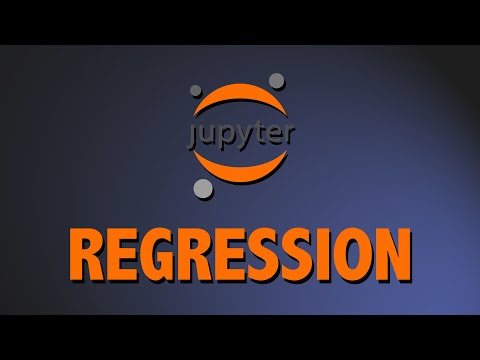

In [34]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('lSUA40VR3LY', width=640, height=360)

# Linear regression

This notebook introduces multiple linear regression for your Reddit data. Linear regressions explain the relationship between a dependent/explanatory variable and an independent/target variable. It is a type of **predictive analysis**. In our case, it can help us find out whether the features or attributes of our Reddit data can predict things like the score of a post. 

The overall idea of regression is to examine:
1. Whether a set of predictor variables does a good job in predicting an outcome (dependent) variable, and 
2. Which variables in particular are significant predictors of the outcome variable

Linear regression tries to fit a linear equation to the observed data in order to explain this relation. It works with *continuous* variables (floats).
- *Simple linear regression* uses a single explanatory variable
- *Multiple linear regression* uses several explanatory variables 

For a basic introduction, see [this video](https://www.youtube.com/watch?v=iIUq0SqBSH0)

This notebook will teach you:

1. Know how to implement multiple linear regression analysis in Python;
2. Understand what kinds of questions you can ask when using regression.

In [1]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import datasets ## imports datasets from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

## Test using California house prices

The California housing dataset includes information on housing prices and possibly correlated features. Let's use it to test a sklearn's `LinearRegression` model.

In [2]:
data = datasets.fetch_california_housing() ## loads California housing dataset from datasets library 

# load up the data
df = pd.DataFrame(data.data, columns=data.feature_names)
# the target/dependent variable is missing. Let's add it to our dataset.
df['MEDV'] = data.target

These are the data we can work with.

The target variable, or independent variable, or Y, that we want to predict is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

The features we can use to do the prediction can be found by running `.DESCR` on the data.



In [3]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

...and here they are in a df:

In [4]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MEDV
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Mapping locations

Before engaging in our linear regression, note that the combination of latitude and longitude data could help us see if there are locations associated with high-valued houses. For instance, we could make a scatterplot where the x- and y-axis would be the latitude and longitude and the circle size and color would be linked with the house value in the district.

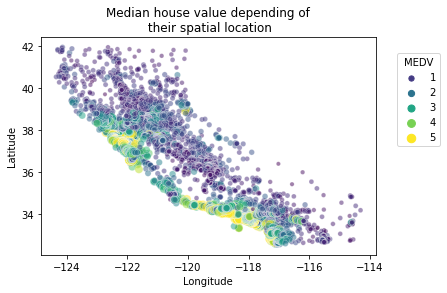

In [5]:
import seaborn as sns

sns.scatterplot(data=df, x="Longitude", y="Latitude",
                size="MEDV", hue="MEDV",
                palette="viridis", alpha=0.5)
plt.legend(title="MEDV", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

These datapoints show a graphical representation of the state of California. High-valued houses tend to be located on the coast, near San Diego, Los Angeles, San Jose, and San Francisco.

### Exploring the data

As we've noted before, exploratory data analysis is a very important step before training the model. You have to know something about the data you analyze in order to do so properly.
We can use some visualizations to understand the relationship of the target variable with other features.

Let's start by looking at our target variable, the median house value.

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


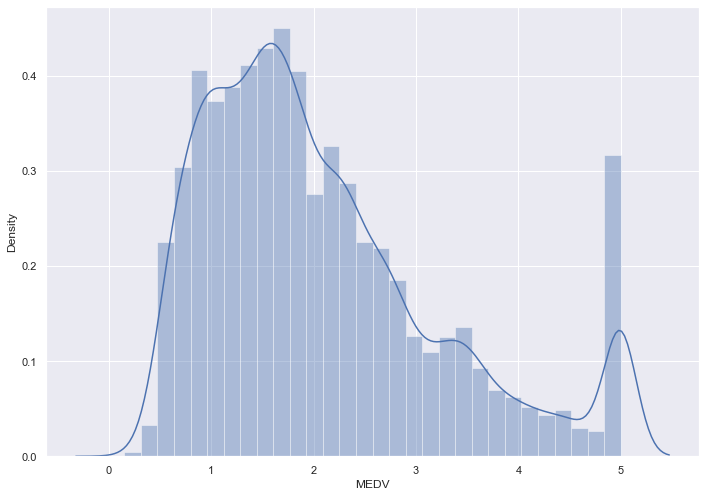

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['MEDV'], bins=30)
plt.show()

We see that the values of MEDV are distributed normally a few outliers for the more expensive properties.

Next, we can create a correlation matrix that measures the linear relationships between the variables. This correlation matrix can be formed by using the `corr` function from the pandas dataframe library. We will use the `heatmap` function from the seaborn library to plot the correlation matrix. This way, we can get an overview of features that seem correlated.

<AxesSubplot:>

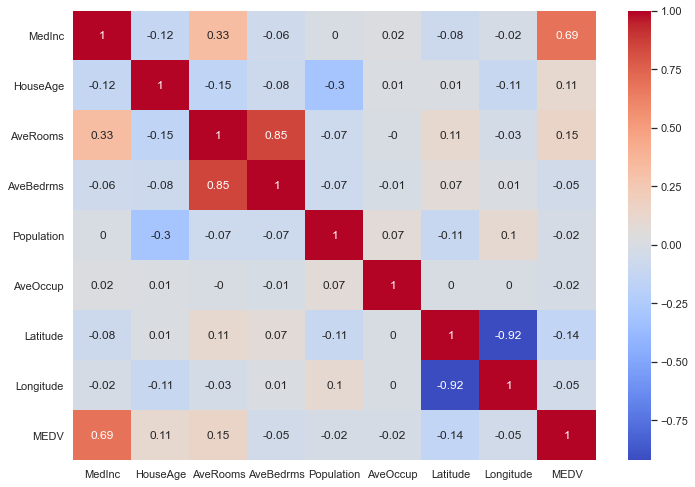

In [7]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm")

The correlation coefficient of these variables ranges from -1 to 1. If the value is close to 1 (dark red), it means that there is a strong positive correlation between the two variables. When it is close to -1 (dark blue), the variables have a strong negative correlation. Can you see the variables that seem to be strongly correlated with MEDV?

### Fitting a model: beware of multicolinearity

To fit a linear regression model, we select those features which have a high correlation with our target variable MEDV. By looking at the correlation matrix we can see that RM has a strong positive correlation with MEDV (0.7) where as LSTAT has a high negative correlation with MEDV(-0.74).

An important point in selecting features for a linear regression model is to check for *multicolinearity*. The features Latitude and Longitude, for instance, have a correlation of 0.92: they are strongly correlated to each other. 

Consider the simplest case where 𝑌 is regressed against 𝑋 and 𝑍 and where 𝑋 and 𝑍 are highly positively correlated. Then the effect of 𝑋 on 𝑌 is hard to distinguish from the effect of 𝑍 on 𝑌 because any increase in 𝑋 tends to be associated with an increase in 𝑍.

For now, we will use the median income in block group and average number of rooms per household as our features. Using a scatter plot, let’s see how these features vary with MEDV.

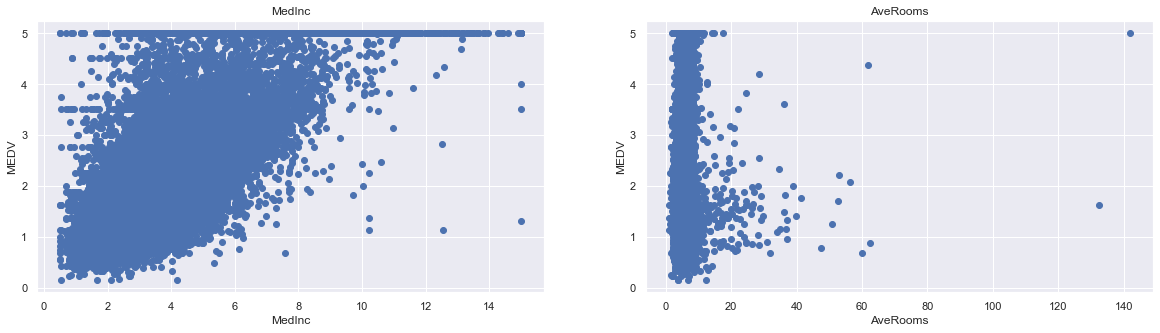

In [8]:
plt.figure(figsize=(20, 5))

features = ['MedInc', 'AveRooms']
target = df['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

As you can see, the prices increase as the median income and the average number of rooms per household increase linearly.

### Splitting the data

Next, we split the data into training and testing sets. We train the model with 80% of the samples and test with the remaining 20%. We do this to assess the model’s performance on unseen data. To split the data we use `train_test_split` function provided by scikit-learn . We finally print the sizes of our training and test set to verify if the splitting has occurred properly.

In [9]:
# Defining independent (X) and dependent (Y) variables
X = df[['MedInc', 'AveRooms']]
Y = df["MEDV"]

In [10]:
# Defining split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16512, 2)
(4128, 2)
(16512,)
(4128,)


Let's fit the model

In [11]:
lm = LinearRegression()
model = lm.fit(X_train, Y_train)

And let's evaluate it using RMSE and R2-score. 

The **RMSE** is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data: how close the observed data points are to the model's predicted values. 

The **R2** socre is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

In [12]:
# model evaluation for training set
y_train_predict = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.8317685105583229
R2 score is 0.4756445698174918


The model performance for testing set
--------------------------------------
RMSE is 0.8360370094765343
R2 score is 0.4933927919020098


In our case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. Let's see what coefficients our regression model has chosen:

In [13]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
MedInc,0.431988
AveRooms,-0.034916


And let's make some predictions.

In [14]:
y_predict = lm.predict(X)
print(y_predict[:5])

[3.93483931 3.95060479 3.42803258 2.81694427 2.02448739]


Finding the intercept and regression coeficient works as follows:

In [15]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 0.5823122862343302
Coefficients: 
 [ 0.43198757 -0.03491573]


Let's print the R² score of our model. This score provides a measure of how well observed outcomes are replicated by our model, based on the proportion of total variation of outcomes explained by the model.

In [16]:
lm.score(X,Y)

0.47935676156925555

### Using `statsmodels`

Let's make another model with `statsmodels`, just to see the difference. The nice thing about `statsmodels` is that it outputs a nice summary of the model, including metrics for model evaluation such as the R-squared value (a value ranging from 0 to 1 that indicates to what extent X perfectly accounts for all the variation in Y).

In [17]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [18]:
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                          6.805e+04
Date:                Wed, 23 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:39:04   Log-Likelihood:                         -26162.
No. Observations:               20640   AIC:                                  5.233e+04
Df Residuals:                   20638   BIC:                                  5.234e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Regressing Reddit data

Now that we've gone through this example, let's try the same with our Reddit data.

In [19]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [20]:
import pandas as pd 

# importing file in df
df = pd.read_csv('aita_sub_top_sm_pos_lemmas_topics.csv')
df.head()

,idint,idstr,created,created_datetime,nsfw,author,title,selftext,lemmas,pos_lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class,dom_topic,dom_topic_num
0,427576402,t3_72kg2a,1506433689,2017-09-26 13:48:09,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,beach friend tiny bikini hate public wear wear...,679.0,NaN,4917.0,434.0,no a--holes here,NaN,friends & dating,15.0
1,551887974,t3_94kvhi,1533404095,2018-08-04 17:34:55,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,parent smoke son week invite parent hour night...,832.0,NaN,2076.0,357.0,asshole,ass,around the house,0.0
2,552654542,t3_951az2,1533562299,2018-08-06 13:31:39,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,obv reason female child area wear thong penis ...,23.0,NaN,1741.0,335.0,Shitpost,NaN,clothes & shopping,12.0
3,556350346,t3_978ioa,1534254641,2018-08-14 13:50:41,0.0,Pauly104,AITA for eating steak in front of my vegan GF?,"Yesterday night, me and my GF decided to go ou...",yesterday night gf decide eat vegan day vegan ...,yesterday night food meal rice girlfriend offe...,1011.0,NaN,416.0,380.0,not the a-hole,not,food,9.0
4,560929656,t3_99yo3c,1535126620,2018-08-24 16:03:40,0.0,ThatSpencerGuy,AITA for not wanting to cook my mother-in-law ...,"My wife and I are vegetarians, much to my in-l...",wife vegetarian law vocal annoyance year visit...,wife year family credit vegetarian dish fill p...,349.0,NaN,1158.0,360.0,not the a-hole,not,food,9.0


Let's look at our Y (dependent variable) – which will be the score.

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


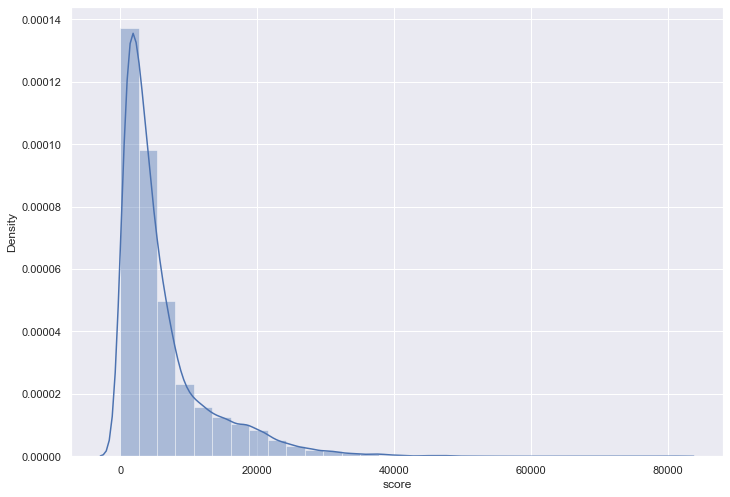

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['score'], bins=30)
plt.show()

<AxesSubplot:>

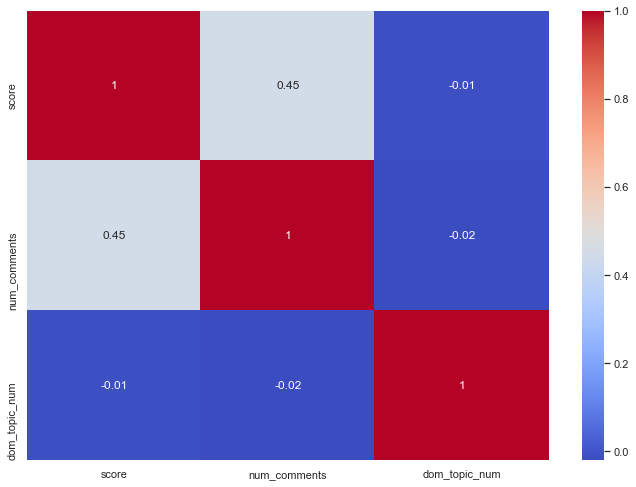

In [22]:
correlation_matrix = df[['score','num_comments','dom_topic_num']].corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm")

Looks like "score" and "num_comments" are weakly correlated. Our dominant topics are not really correlated at all. Let's plot the features.

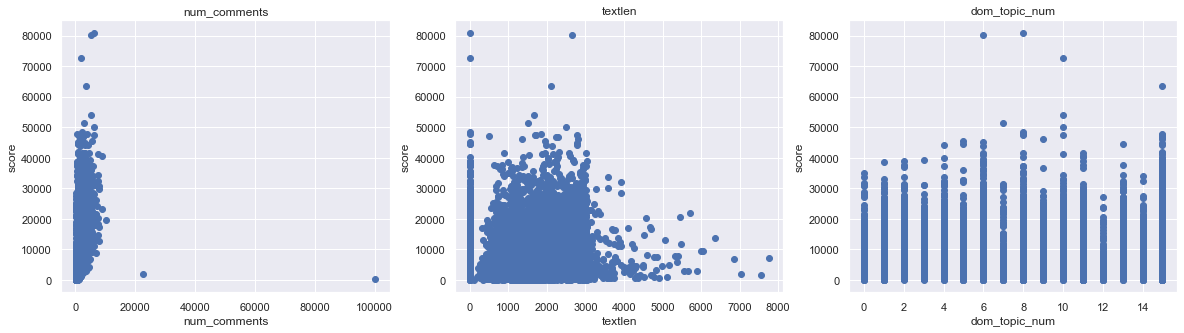

In [23]:
plt.figure(figsize=(20, 5))

features = ['num_comments', 'textlen', 'dom_topic_num']
target = df['score']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('score')

In [24]:
# define the data/predictors a X
X = df[['num_comments']]

# Put the target (housing value -- MEDV) in another DataFrame
Y = df[['score']]

In [25]:
# Defining split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13048, 1)
(3262, 1)
(13048, 1)
(3262, 1)


In [26]:
lm = LinearRegression()
model = lm.fit(X_train, Y_train)

And let's evaluate it using RMSE and R2-score. 

In [27]:
# model evaluation for training set
y_train_predict = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5192.999674376303
R2 score is 0.39985733540535706


The model performance for testing set
--------------------------------------
RMSE is 10494.285567869536
R2 score is -1.4674629350886348


In our case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. Let's see what coefficients our regression model has chosen:

In [28]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
num_comments,5.26233


And let's make some predictions:

In [29]:
y_predict = lm.predict(X)
print(y_predict[:5])

[[3714.43179932]
 [3309.23237145]
 [3193.46110635]
 [3430.26596679]
 [3325.01936215]]


Finding the intercept and regression coeficient:

In [30]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 [1430.58047863]
Coefficients: 
 [[5.26233023]]


Let's print the R² score of our model. This score provides a measure of how well observed outcomes are replicated by our model, based on the proportion of total variation of outcomes explained by the model.

In [31]:
lm.score(X,Y)

0.028412579097440882

Let's see the output of `statsmodels` as well. For more info on how to interpret R-squared values, see https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

In [32]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [33]:
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                  score   R-squared (uncentered):                   0.469
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                          1.441e+04
Date:                Wed, 23 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:39:10   Log-Likelihood:                     -1.6664e+05
No. Observations:               16310   AIC:                                  3.333e+05
Df Residuals:                   16309   BIC:                                  3.333e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### What to do next?

Note that with the NLP approaches we have used, you could do some "feature extraction" of your own: for instance, by counting the appearance of **particular words** and using that as a dependent variable to predict scores. 